In [4]:
!pip3 install pmdarima

In [5]:
# Import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


warnings.simplefilter('ignore')

In [6]:
data = pd.read_csv('Dataset2_month_temp.csv',names = ['month_temp'])


**Applying KPSS and ADF test**

1. ADF test

In [7]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = data[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('month_temp')

Results of Dickey-Fuller Test for  month_temp 

Test Statistic                  -4.044912
p-value                          0.001193
#Lags Used                       3.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


2. KPSS test

In [8]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(atr):
    timeseries = data[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('month_temp')

Results of KPSS Test for  month_temp
Test Statistic            0.664381
p-value                   0.016784
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


For ADF test, we can see that the p-value  is  below 0.05. Thus, from ADF test, we can say that the dataset is stationary.

For KPSS test, Test Statistic is more than Critical Value, thus we reject the null hypothesis. Thus, from KPSS test, we can say that the dataset is non-stationary.

Since, both tests conclude that the series is stationary, therefore, the dataset is concluded as Difference-Stationary.



---



Making dataset stationary with differencing


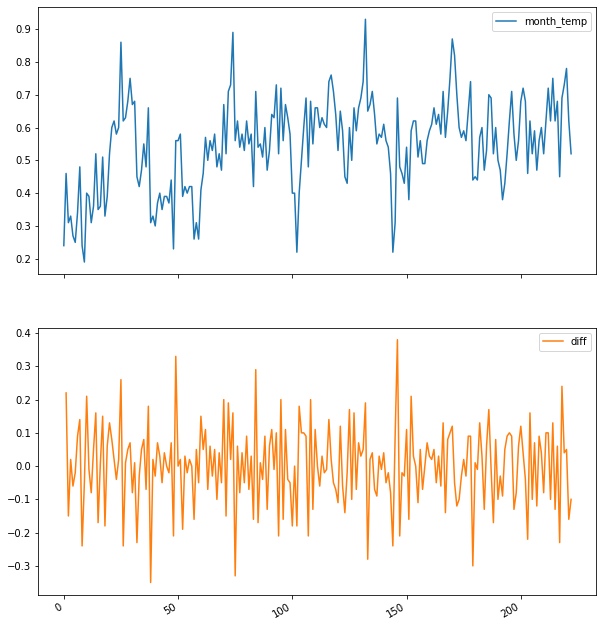

In [9]:
# Differencing
data['diff'] = data['month_temp'].diff(periods=1)

data.plot(subplots=True, figsize=(10,12))
plt.show()



---



Applying Exponential Smoothening

In [10]:
#List of least mse and mae
mseses=[]
msedes=[]
msetes=[]
maeses=[]
maedes=[]
maetes=[]

**Single Exponential Smoothing**

In [11]:
#Defining Single Exponential Smoothing function ses
def ses(arr,alpha):
    arr1 = [arr[0]]
    for i in range(1, len(arr)):
        arr1.append(alpha * arr[i-1] + (1 - alpha) * arr1[i-1])
    return arr1

In [12]:
#Defining Mean of Squared Error Function mse
def mse(arr1,arr2):
  arr3=[0]
  for i, j in zip(arr1, arr2):
    arr3.append(i-j)
  Sum=0
  for i in arr3:
    sqr=i**2
    Sum+=sqr
  mse=Sum/(len(arr2)-1)
  return mse

In [13]:
#Function to make list of demand with interval 'n'
def dem_n(arr,n):
  arr1=[arr[0]]
  for i in range(1,len(arr)):
    if i%n==0:  
      arr1.append(arr[i])
  return arr1

In [14]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,1)

In [15]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [16]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.012776241365066766
Mean of Square Errors for alpha = 0.5 is:  0.011783265150351989
Mean of Square Errors for alpha = 0.8 is:  0.012865803390005504


In [17]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8 is: ",mae3)

Mean Absolute Errors for alpha = 0.2 is:  0.08991859036980403
Mean Absolute Errors for alpha = 0.5 is:  0.087340641452764
Mean Absolute Errors for alpha = 0.8 is:  0.09010946336491085


alpha:  0.5


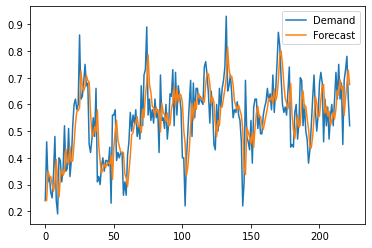

In [18]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])


**Double Exponential Smoothing**

In [19]:
#Defining Double Exponential Smoothing function des
def des(arr,alpha,beta):
  a=[arr[0]]
  l=len(arr)
  b=[(arr[l-1]-arr[0])/(l-1)]
  arr1 = [arr[0]]
  arr1.append(a[0]+b[0])
  for i in range(1,len(arr)-1):
      a.append(alpha * arr[i] + (1 - alpha) * (a[i-1]+b[i-1]))
      b.append(beta * (a[i]-a[i-1]) + (1 - beta) * (b[i-1]))        
      arr1.append(a[i]+b[i])
  return arr1

In [20]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,1)

In [21]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [22]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.016344385097743625
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.016752197412308715
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.02435074881446847


In [23]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3 is:  0.10489883193358056
Mean Absolute Errors for alpha = 0.5,beta= 0.6 is:  0.1024506218200433
Mean Absolute Errors for alpha = 0.8,beta= 0.9 is:  0.121427472738696


alpha:  0.2
beta:  0.3


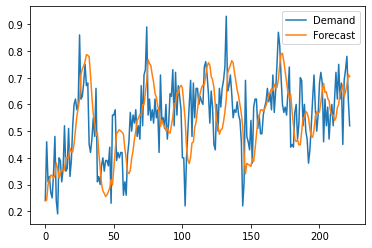

In [24]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])

**Triple Exponential Smoothing**

In [25]:
#Defining initial trend
def initial_trend(arr, slen):
    Sum = 0
    for i in range(slen):
        Sum += float(arr[i+slen] - arr[i]) / slen
    return Sum / slen

In [26]:
#Defining initial seasonal
def initial_seasonal(arr, slen):
    arr1 = {}
    s_avg = []
    m = int(len(arr)/slen)
    for j in range(m):
        s_avg.append(sum(arr[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        Sum = 0
        for j in range(m):
            Sum += arr[slen*j+i]-s_avg[j]
        arr1[i] = Sum/m
    return arr1

In [27]:
#Defining Triple Exponential Smoothing function tes with interval 'n'
def tes(arr, slen, alpha, beta, gamma, n):
    arr1 = []
    seasonals = initial_seasonal(arr, slen)
    for i in range(len(arr)+n):
        if i == 0:
            smooth = arr[0]
            trend = initial_trend(arr, slen)
            arr1.append(arr[0])
            continue
        if i >= len(arr):
            m = i - len(arr) + 1
            arr1.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = arr[i]
            lsmooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-lsmooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            arr1.append(smooth+trend+seasonals[i%slen])
    return arr1

In [28]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,1)

In [29]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [30]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.006142178171985968
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.0011599649951772768
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.006329173898406177


In [31]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.0526621870388914
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.02413624022372913
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.06325534048617418


alpha:  0.5
beta:  0.6
gamma:  0.7


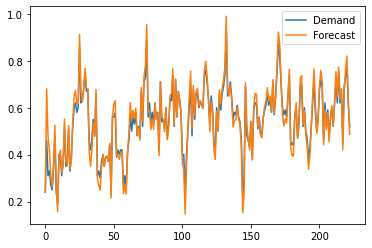

In [32]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])



---



For 1 Unit

**Single Exponential Smoothing**

In [33]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,1)

In [34]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [35]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.012776241365066766
Mean of Square Errors for alpha = 0.5 is:  0.011783265150351989
Mean of Square Errors for alpha = 0.8 is:  0.012865803390005504


alpha:  0.5


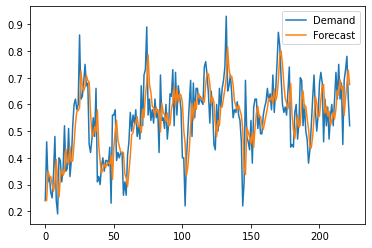

In [36]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [37]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [38]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,1)

In [39]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [40]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.016344385097743625
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.016752197412308715
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.02435074881446847


alpha:  0.2
beta:  0.3


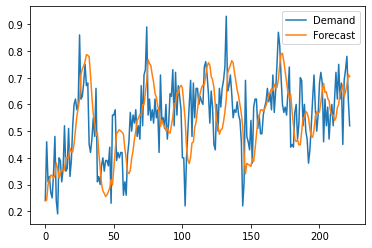

In [41]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [42]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [43]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,1)

In [44]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [45]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.006142178171985968
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.0011599649951772768
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.006329173898406177


In [46]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.0526621870388914
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.02413624022372913
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.06325534048617418


alpha:  0.5
beta:  0.6
gamma:  0.7


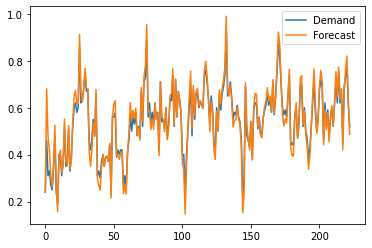

In [47]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [48]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 2 Unit

**Single Exponential Smoothing**

In [49]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,2)

In [50]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [51]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.016080961425601354
Mean of Square Errors for alpha = 0.5 is:  0.015120728666467782
Mean of Square Errors for alpha = 0.8 is:  0.016803794493335546


alpha:  0.5


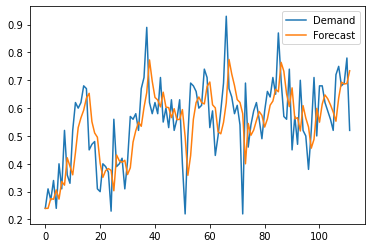

In [52]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [53]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [54]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,2)

In [55]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [56]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.021743706689690372
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.021152519593798498
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.032303830991147524


alpha:  0.5
beta:  0.6


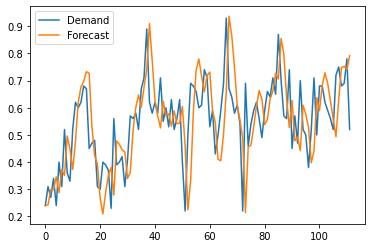

In [57]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [58]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [59]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,2)

In [60]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [61]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.004171315216015895
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.0010530392502876376
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.008109326159268706


In [62]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.05171209685741829
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.026731750173506715
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.07085378916000452


alpha:  0.5
beta:  0.6
gamma:  0.7


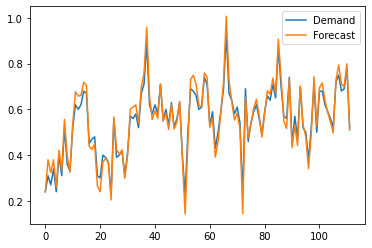

In [63]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [64]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 4 Unit

**Single Exponential Smoothing**

In [65]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,4)

In [66]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [67]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.019573996145141943
Mean of Square Errors for alpha = 0.5 is:  0.017969169959880345
Mean of Square Errors for alpha = 0.8 is:  0.018292660563368656


alpha:  0.5


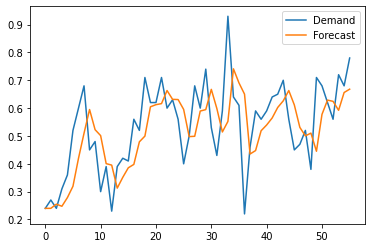

In [68]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [69]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [70]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,4)

In [71]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [72]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.022918530300947426
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.026714583491085346
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.032875219237949706


alpha:  0.2
beta:  0.3


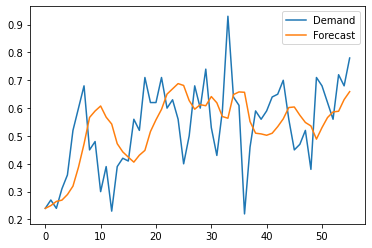

In [73]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [74]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [75]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,4)

In [76]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [77]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.004366820789674877
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.0014247816969603806
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.009108135677565483


In [78]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.05049346336504821
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.03173745827232747
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.07327609377920521


alpha:  0.5
beta:  0.6
gamma:  0.7


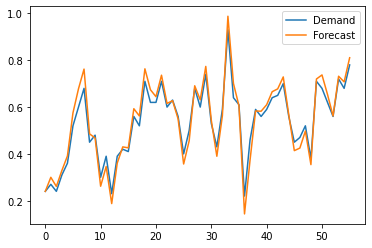

In [79]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [80]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 8 Unit

**Single Exponential Smoothing**

In [81]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,8)

In [82]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [83]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.02195913607989374
Mean of Square Errors for alpha = 0.5 is:  0.02081324209758422
Mean of Square Errors for alpha = 0.8 is:  0.022605624476612792


alpha:  0.5


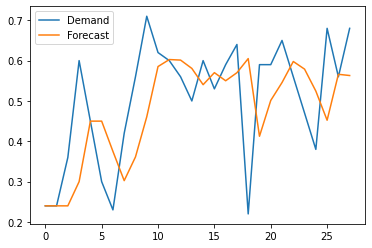

In [84]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [85]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [86]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,8)

In [87]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [88]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.021507331873940945
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.03126182928406941
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.042888512013966436


alpha:  0.2
beta:  0.3


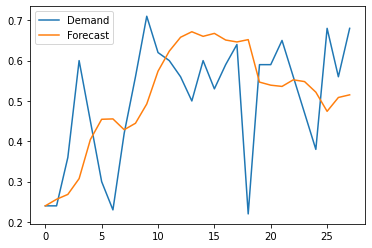

In [89]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [90]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [91]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,8)

In [92]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [93]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.004688438880967469
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.001309053829376328
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.011092396420127158


In [94]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.05491616937825304
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.027618075773923143
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.0823281154744975


alpha:  0.5
beta:  0.6
gamma:  0.7


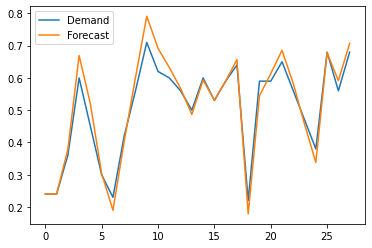

In [95]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [96]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 12 Unit

**Single Exponential Smoothing**

In [97]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,12)

In [98]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [99]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.04361094545399775
Mean of Square Errors for alpha = 0.5 is:  0.04464140278196214
Mean of Square Errors for alpha = 0.8 is:  0.05507685799681031


alpha:  0.2


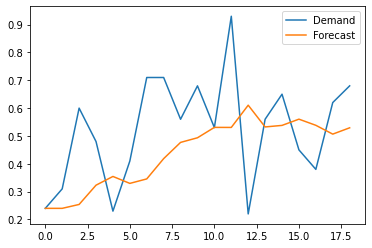

In [100]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [101]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [102]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,12)

In [103]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [104]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.0439398263063909
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.05824152657925115
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.11450367969557813


alpha:  0.2
beta:  0.3


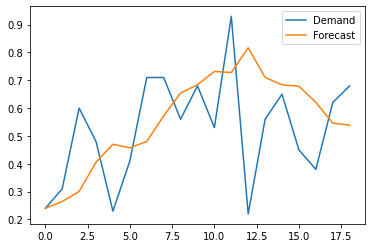

In [105]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [106]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [107]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,12)

In [108]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [109]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.014130607318364134
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.002819566009035683
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.025998330476397213


In [110]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.08899122356016119
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.04068580726768734
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.1283092776849997


alpha:  0.5
beta:  0.6
gamma:  0.7


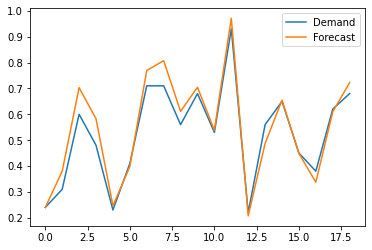

In [111]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [112]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 24 Interval

**Single Exponential Smoothing**

In [113]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,24)

In [114]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [115]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.053274637834819075
Mean of Square Errors for alpha = 0.5 is:  0.05612971008300782
Mean of Square Errors for alpha = 0.8 is:  0.07436831967254126


alpha:  0.2


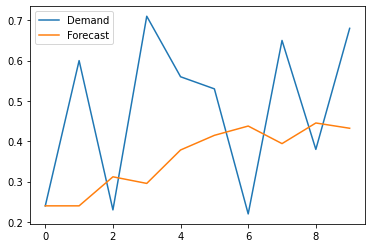

In [116]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [117]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [118]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,24)

In [119]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [120]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.05175964453756846
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.07134782394074757
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.1446453483548052


alpha:  0.2
beta:  0.3


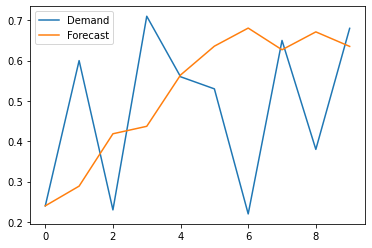

In [121]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

**Triple Exponential Smoothing**

In [122]:
#Creating demand list in 'n' intervals
demand=dem_n(data.month_temp,24)

In [123]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [124]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.1873689547447504
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.02574568178093526
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.03907104292904815


In [125]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.3890806247672641
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.10894441517707029
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.1609046455657641


alpha:  0.5
beta:  0.6
gamma:  0.7


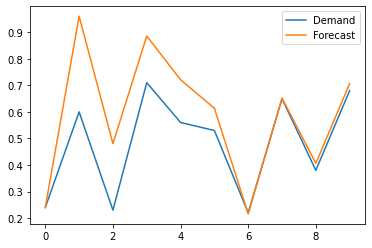

In [126]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [127]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)



---

Least MSE and MAE values are


In [128]:
print("Least MSE ses")
print(mseses)
print("Least MSE des")
print(msedes)
print("Least MSE tes")
print(msetes)


print("Least MAE ses")
print(maeses)
print("Least MAE des")
print(maedes)
print("Least MAE tes")
print(maetes)


Least MSE ses
[0.011783265150351989, 0.015120728666467782, 0.017969169959880345, 0.02081324209758422, 0.04361094545399775, 0.053274637834819075]
Least MSE des
[0.016344385097743625, 0.021152519593798498, 0.022918530300947426, 0.021507331873940945, 0.0439398263063909, 0.05175964453756846]
Least MSE tes
[0.0011599649951772768, 0.0010530392502876376, 0.0014247816969603806, 0.001309053829376328, 0.002819566009035683, 0.02574568178093526]
Least MAE ses
[0.02413624022372913, 0.02413624022372913, 0.026731750173506715, 0.03173745827232747, 0.027618075773923143, 0.04068580726768734]
Least MAE des
[0.02413624022372913, 0.02413624022372913, 0.026731750173506715, 0.03173745827232747, 0.027618075773923143]
Least MAE tes
[0.02413624022372913, 0.026731750173506715, 0.03173745827232747, 0.027618075773923143, 0.04068580726768734, 0.10894441517707029]




---



Applying ACF and PACF

<function matplotlib.pyplot.show>

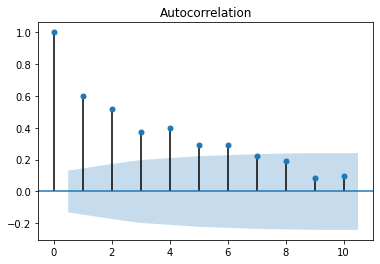

In [129]:
#Plotting ACF
plot_acf(data.month_temp,lags=10)
plt.show

<function matplotlib.pyplot.show>

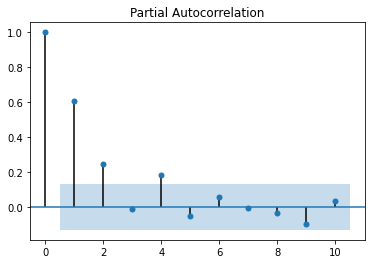

In [130]:
#plotting PACF
plot_pacf(data.month_temp,lags=10)
plt.show



---



Applying AR, MA, ARIMA Models

                              ARMA Model Results                              
Dep. Variable:             month_temp   No. Observations:                  223
Model:                     ARMA(2, 0)   Log Likelihood                 184.583
Method:                       css-mle   S.D. of innovations              0.106
Date:                Mon, 01 Mar 2021   AIC                           -361.166
Time:                        05:27:59   BIC                           -347.537
Sample:                             0   HQIC                          -355.664
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5415      0.024     22.716      0.000       0.495       0.588
ar.L1.month_temp     0.4652      0.066      7.094      0.000       0.337       0.594
ar.L2.month_temp     0.2421 

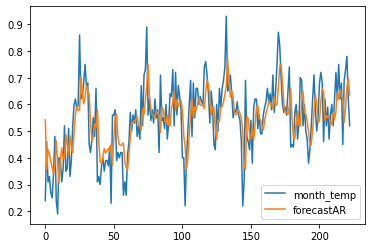

In [131]:
#AR

#fit model
model=ARIMA(data['month_temp'], order=(2,0,0))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastAR'] = model_fit.predict()
data[['month_temp','forecastAR']].plot()

In [132]:
mse=mean_squared_error(data.month_temp,data.forecastAR.dropna())
print("MSE for AR is:",mse)

MSE for AR is: 0.011324876395756103


In [133]:
mae=mean_absolute_error(data.month_temp,data.forecastAR.dropna())
print("MAE for AR is:",mae)

MAE for AR is: 0.08527310148432576


                              ARMA Model Results                              
Dep. Variable:             month_temp   No. Observations:                  223
Model:                     ARMA(0, 3)   Log Likelihood                 175.843
Method:                       css-mle   S.D. of innovations              0.110
Date:                Mon, 01 Mar 2021   AIC                           -341.686
Time:                        05:28:00   BIC                           -324.650
Sample:                             0   HQIC                          -334.808
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5436      0.015     37.362      0.000       0.515       0.572
ma.L1.month_temp     0.5122      0.071      7.177      0.000       0.372       0.652
ma.L2.month_temp     0.3829 

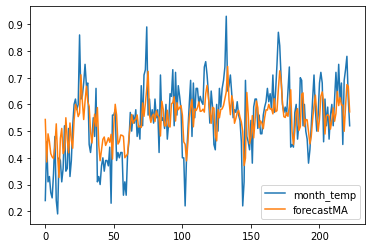

In [134]:
#MA

#fit model
model=ARIMA(data['month_temp'].dropna(), order=(0,0,3))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastMA'] = model_fit.predict()
data[['month_temp','forecastMA']].plot()

In [135]:
mse=mean_squared_error(data.month_temp,data.forecastMA.dropna())
print("MSE for MA is:",mse)

MSE for MA is: 0.012199643481877933


In [136]:
mae=mean_absolute_error(data.month_temp,data.forecastMA.dropna())
print("MAE for MA is:",mae)

MAE for MA is: 0.08773075322053521


                              ARMA Model Results                              
Dep. Variable:                   diff   No. Observations:                  222
Model:                     ARMA(2, 3)   Log Likelihood                 188.188
Method:                       css-mle   S.D. of innovations              0.103
Date:                Mon, 01 Mar 2021   AIC                           -362.375
Time:                        05:28:01   BIC                           -338.557
Sample:                             0   HQIC                          -352.759
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.982      0.003       0.000       0.001
ar.L1.diff    -0.1780      0.110     -1.619      0.106      -0.394       0.038
ar.L2.diff     0.6585      0.109      6.060      0.0

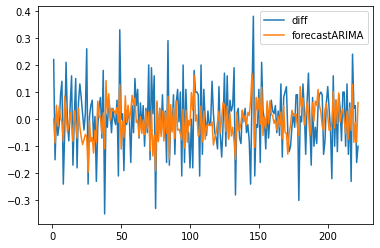

In [137]:
#ARIMA

#fit model
model=ARIMA(data['diff'].dropna(), order=(2,0,3))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastARIMA'] = model_fit.predict()
data[['diff','forecastARIMA']].plot()

In [139]:
mse=mean_squared_error(data.month_temp[0:-1],data.forecastARIMA.dropna())
print("MSE for MA is:",mse)

MSE for MA is: 0.3383298281790968


In [140]:
mae=mean_absolute_error(data.month_temp[0:-1],data.forecastARIMA.dropna())
print("MAE for MA is:",mae)

MAE for MA is: 0.5506916595028443




---



Applying Auto ARIMA

In [141]:
import pmdarima as pm
model = pm.auto_arima(data.iloc[:,0], start_p=1, start_q=1,test='adf',max_p=3, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0, trace=True,error_action='ignore',  suppress_warnings=True,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-348.834, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=377.837, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-305.484, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=164.742, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-350.560, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-337.521, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-355.547, Time=0.30 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-356.991, Time=0.57 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-347.901, Time=0.36 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-354.965, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-355.692, Time=0.40 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-363.650, Time=0.66 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-363.197, Time=0.67 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AI

# Best model:  ARIMA(2,0,3)(0,0,0)[0]


Final Result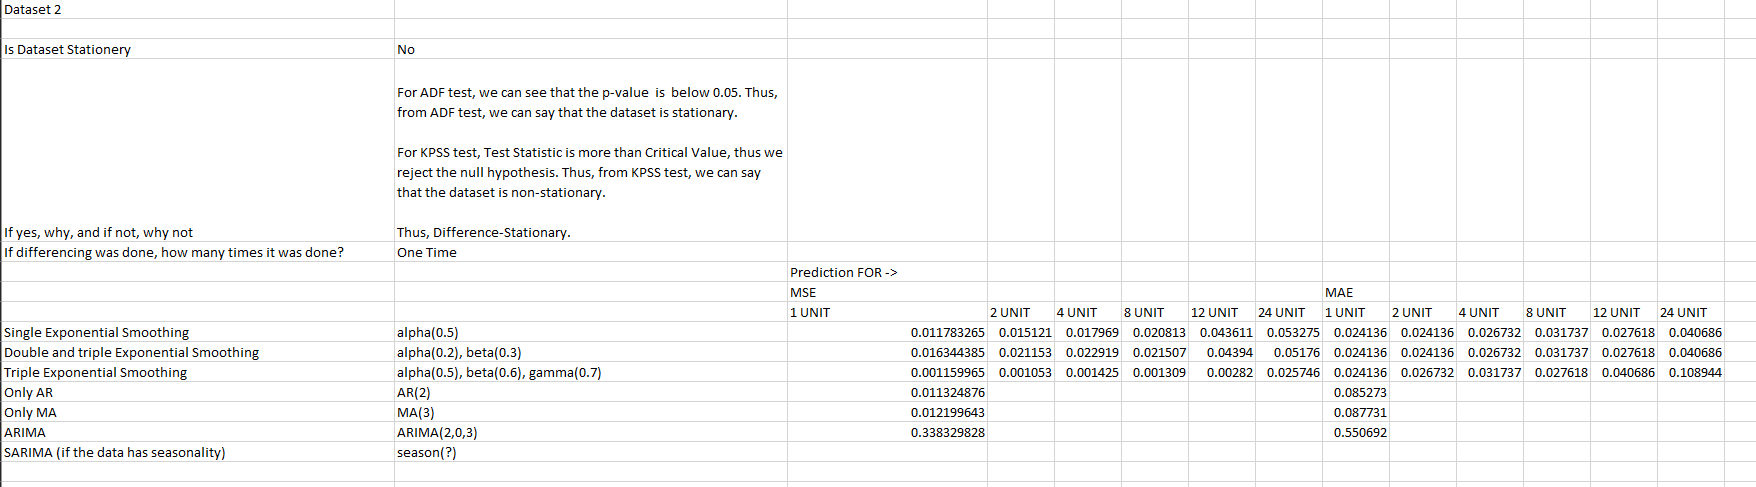